# NLP IMDB Reviews Classification Machine Learning

Project Report by Allentine Paulis

# Table of Contents
* [Project Statement](#description-id)
* [Data](#data)
* [Step 1. Initialization](#initial-id)
* [Step 2. Load Data](#load)
* [Step 3. EDA](#eda)
* [Step 4. Evaluation Procedure](#evaluation) 
* [Step 5. Normalization](#normalization)
* [Step 6. Train/Test Split](#split)
* [Step 7. Working with Models](#model)
    * [7.1 Model 0 - Constant](#constant)
    * [7.2 Model 1 - NLTK, TF-IDF and LR](#nltk)
    * [7.2 Model 3 - spaCy, TF-IDF and LR](#spacy)
    * [7.3 Model 4 - spaCy, TF-IDF and LGBMClassifier](#lgbm)
    * [7.5 Model 9 - BERT](#bert)
    * [7.6 Evaluation Model](#modelevaluation)
* [Step 8. Reviews](#reviews) 
    * [8.1 Model 1 - NLTK, TF-IDF and LR](#nltk)
    * [8.2 Model 3 - spaCy, TF-IDF and LR](#spacy)
    * [8.3 Model 4 - spaCy, TF-IDF and LGBMClassifier](#lgbm)
    * [8.4 Model 9 - BERT](#bert)
* [Step 9. Overall conclusion](#allconclusion)

# Project Statement <a class="anchor" id="description-id"></a>

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

# Data <a class="anchor" id="data"></a>
The data was provided by Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

Here's the description of the selected fields:
- `review`: the review text
- `pos`: the target, '0' for negative and '1' for positive
- `ds_part`: 'train'/'test' for the train/test part of dataset, correspondingly

There are other fields in the dataset. Feel free to explore them if you'd like.

## Initialization <a class="anchor" id="initial-id"></a>

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import re
import nltk
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data <a class="anchor" id="load"></a>

In [4]:
df_reviews = pd.read_csv('https://code.s3.yandex.net/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.duplicated().sum()

0

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
tconst             47331 non-null object
title_type         47331 non-null object
primary_title      47331 non-null object
original_title     47331 non-null object
start_year         47331 non-null int64
end_year           47331 non-null object
runtime_minutes    47331 non-null object
is_adult           47331 non-null int64
genres             47331 non-null object
average_rating     47329 non-null float64
votes              47329 non-null Int64
review             47331 non-null object
rating             47331 non-null int64
sp                 47331 non-null object
pos                47331 non-null int64
ds_part            47331 non-null object
idx                47331 non-null int64
dtypes: Int64(1), float64(1), int64(5), object(10)
memory usage: 6.2+ MB


In [8]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [9]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [10]:
df_reviews.isna().sum()/len(df_reviews)*100

tconst             0.000000
title_type         0.000000
primary_title      0.000000
original_title     0.000000
start_year         0.000000
end_year           0.000000
runtime_minutes    0.000000
is_adult           0.000000
genres             0.000000
average_rating     0.004226
votes              0.004226
review             0.000000
rating             0.000000
sp                 0.000000
pos                0.000000
ds_part            0.000000
idx                0.000000
dtype: float64

In [11]:
df_reviews[df_reviews["average_rating"].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,NaN,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [12]:
# There are two rows with nulls and the percentage is so small, we can remove them
df_reviews = df_reviews[~df_reviews["average_rating"].isna()]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


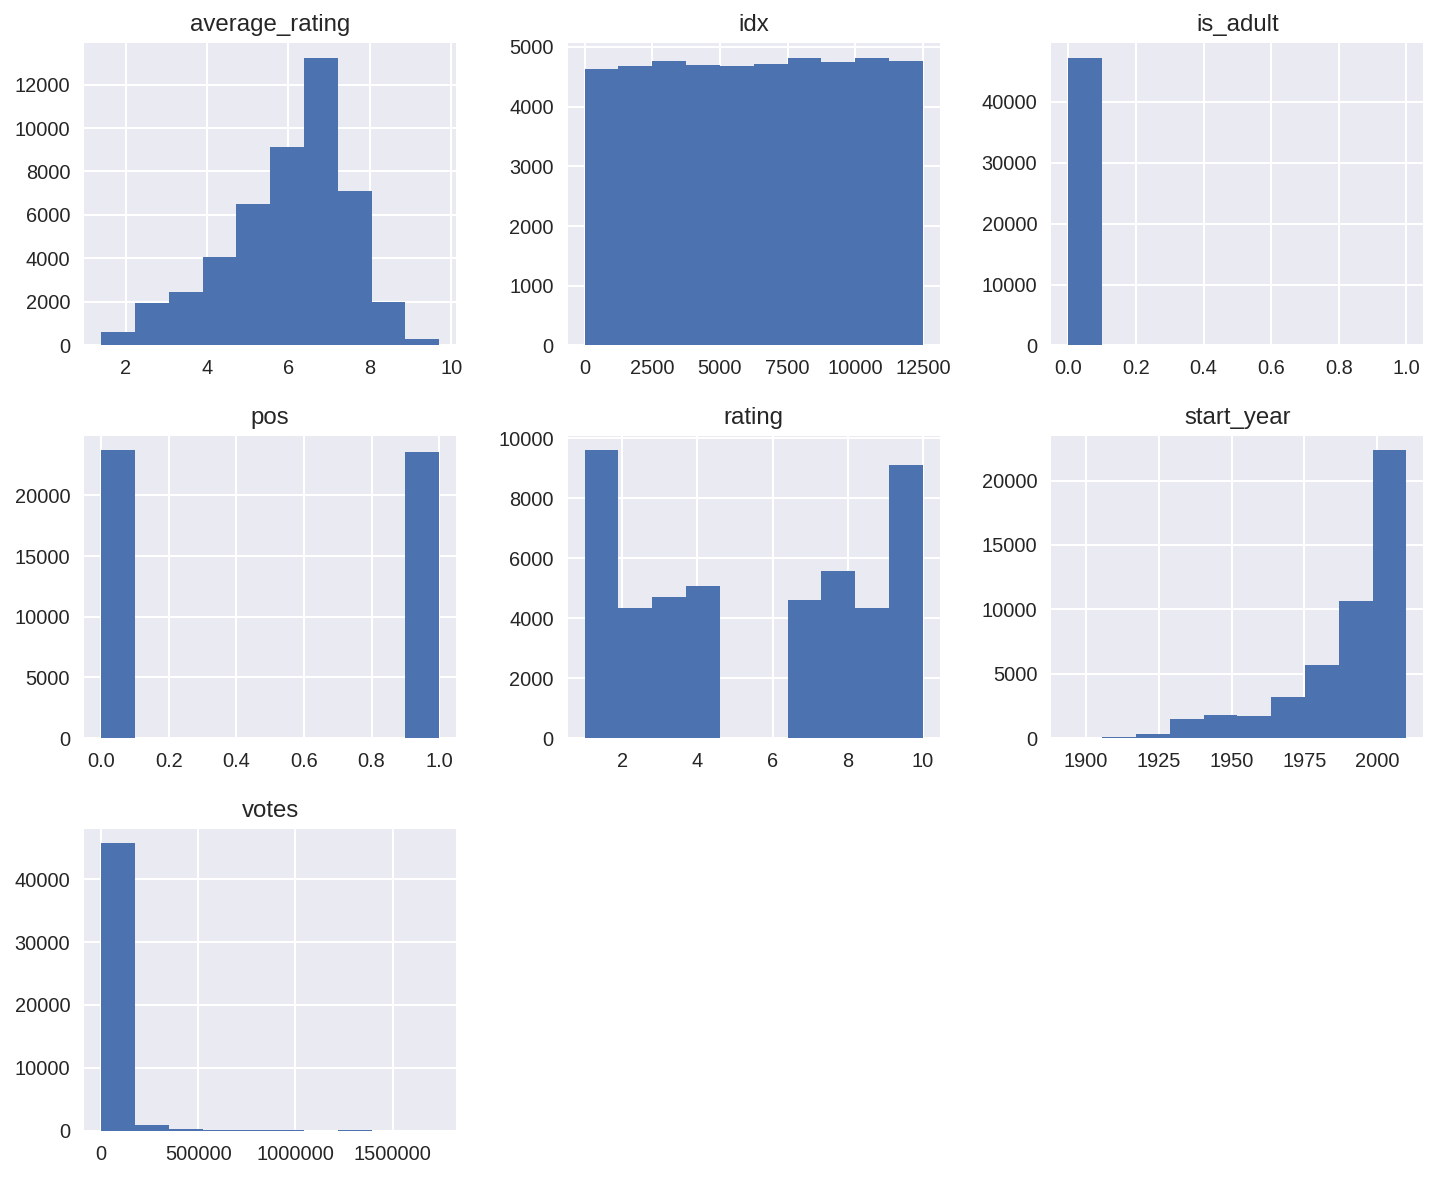

In [13]:
fig = plt.figure(figsize = (12,10))
ax = fig.gca()
df_reviews.hist(ax = ax)
fig = ax.get_figure()

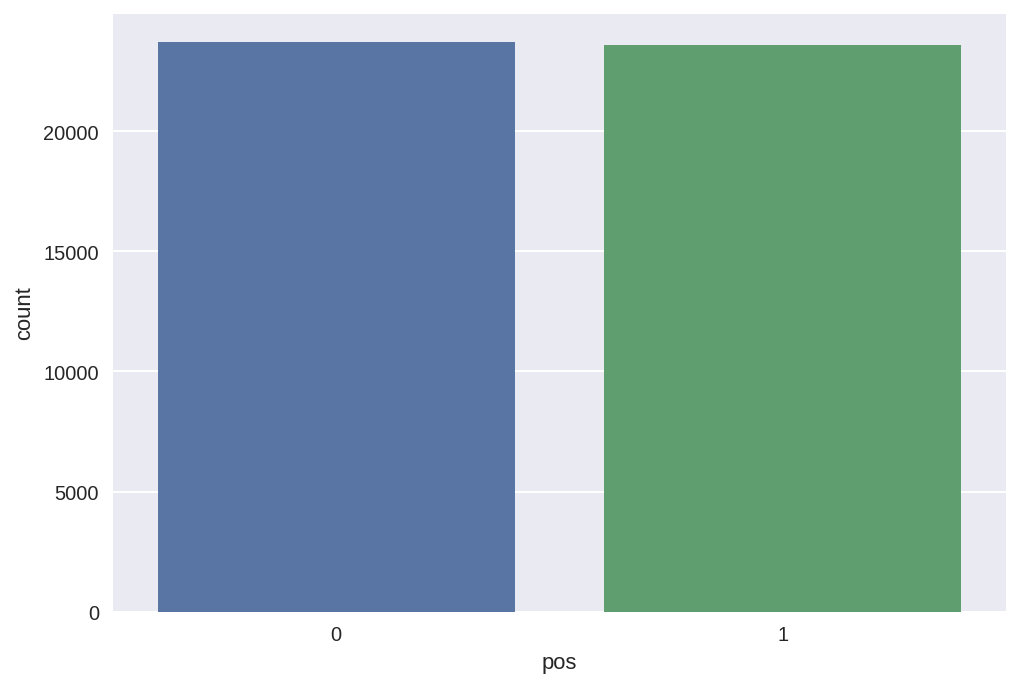

In [14]:
sns.countplot(df_reviews["pos"])

In [15]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

The target dataset is balanced.

## EDA <a class="anchor" id="eda"></a>

Let's check the number of movies and reviews over years.

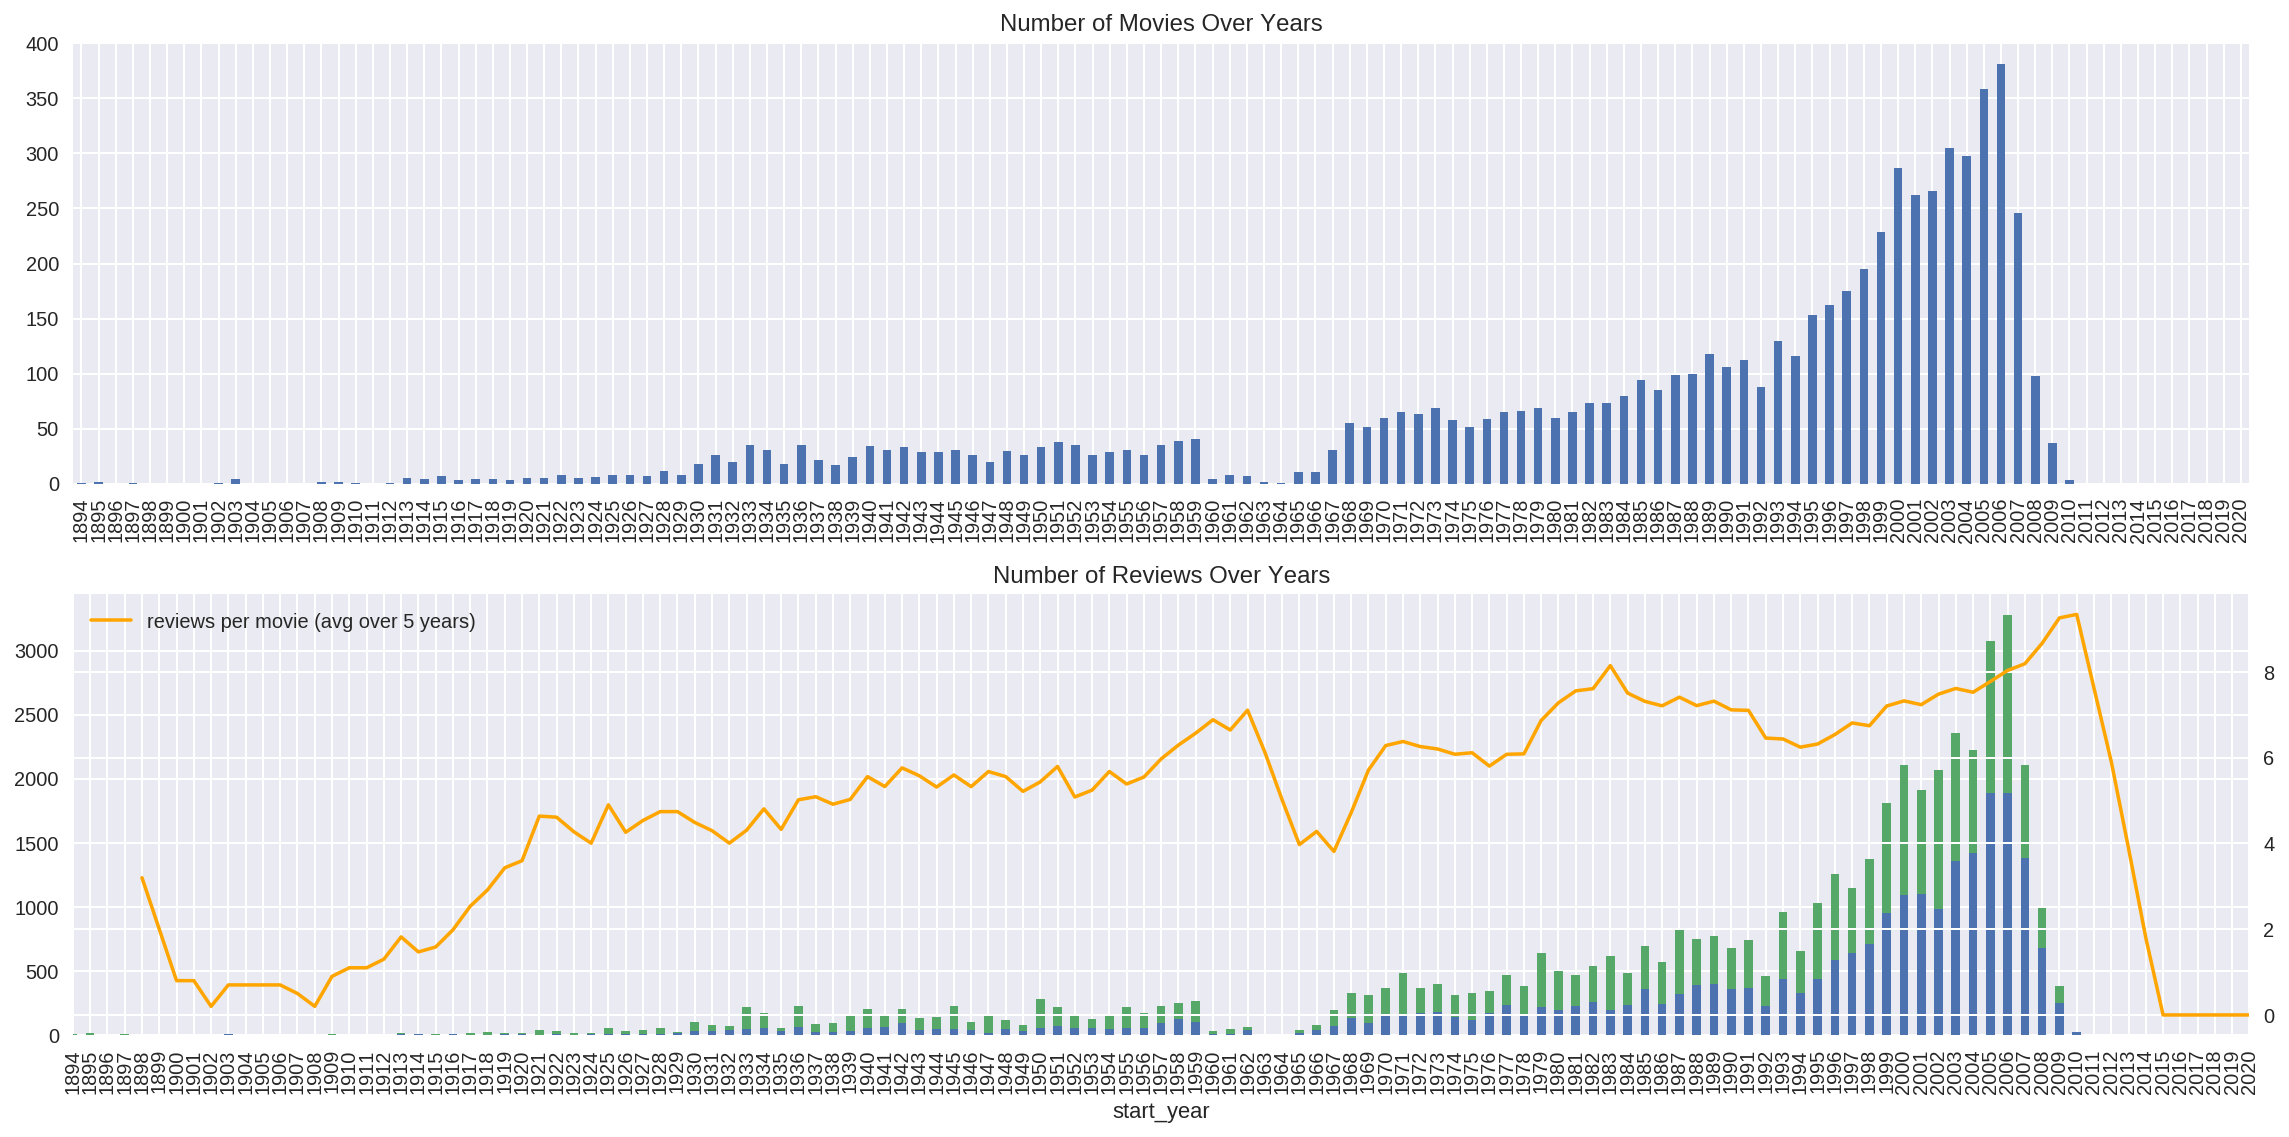

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

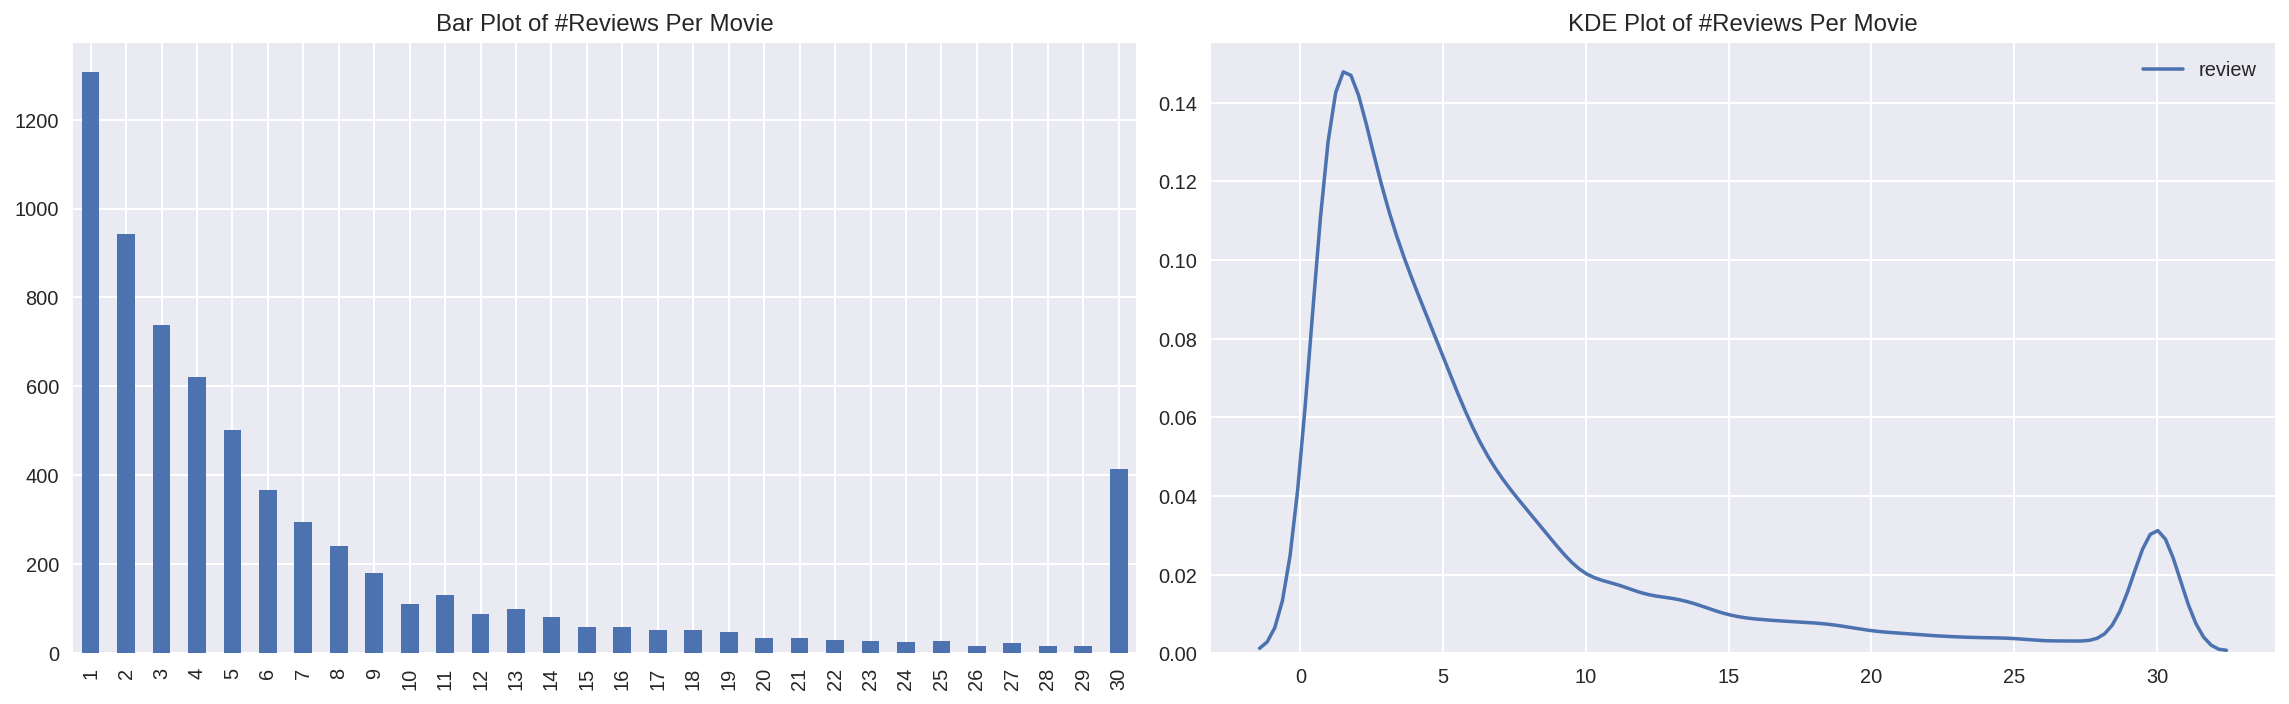

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

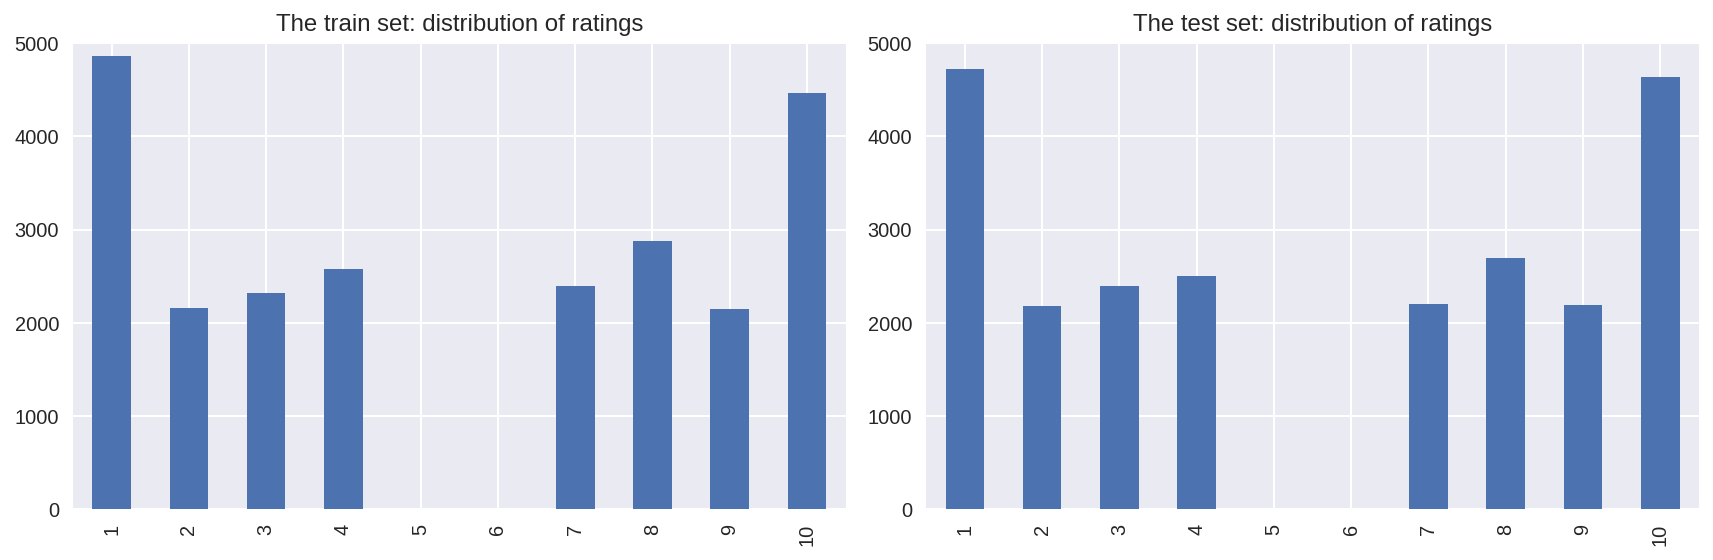

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

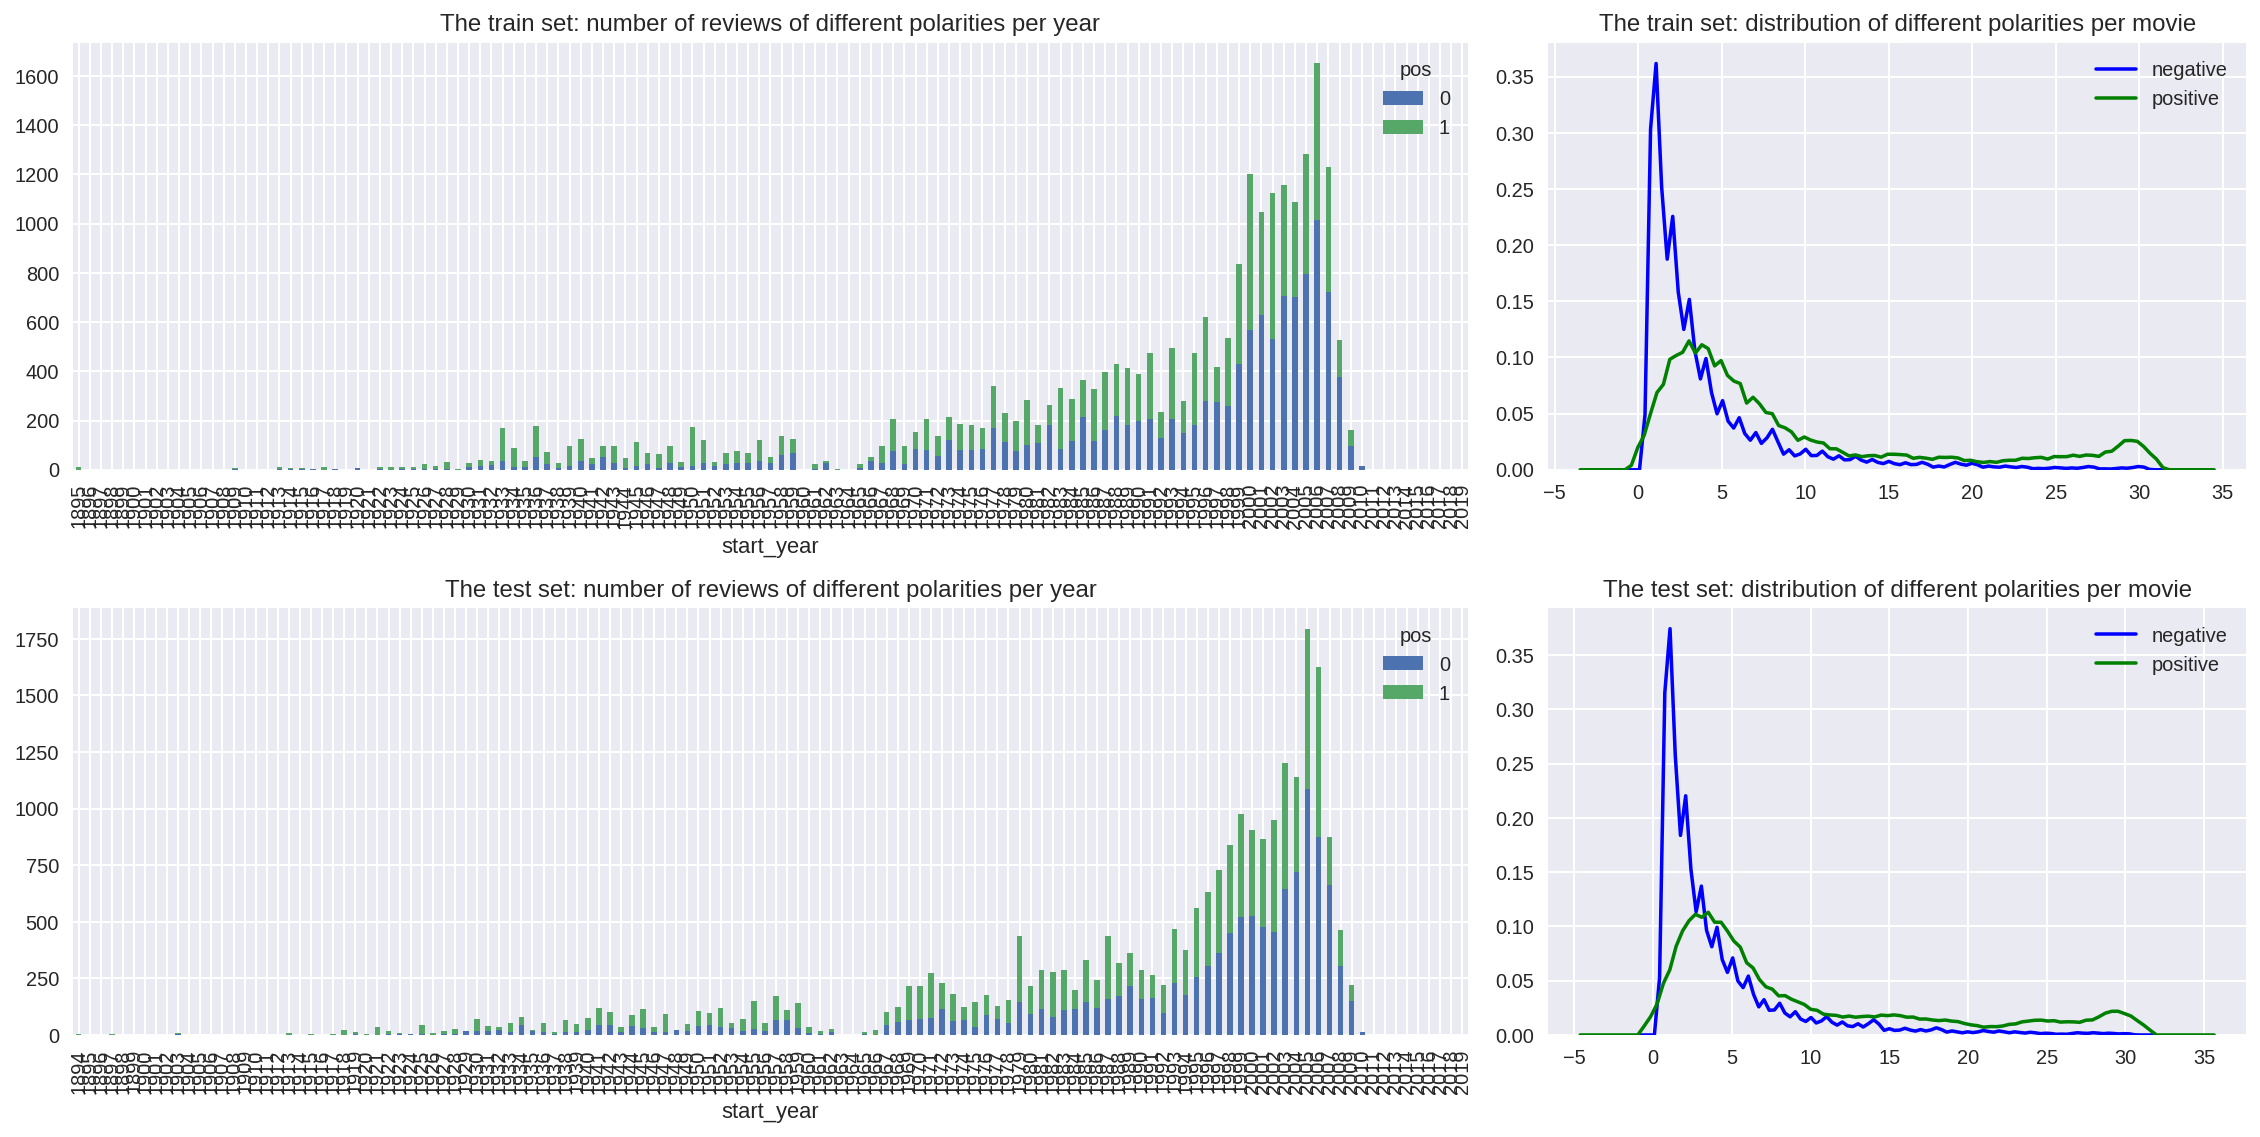

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure<a class="anchor" id="evaluation"></a>

Composing an evaluation routine which can be used for all models in this project

In [20]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization <a class="anchor" id="normalization"></a>

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [21]:
def clean_text(row):
    text = row['review']
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    text = text.split()
    text = " ".join(text)    
    return text

In [22]:
df_reviews['review_norm'] = df_reviews.apply(clean_text, axis=1)

In [23]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i'm totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Train / Test Split <a class="anchor" id="split"></a>

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [24]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


In [25]:
train_features =   df_reviews_train.drop('pos', axis=1)
test_features =  df_reviews_test.drop('pos', axis=1)

## Working with models <a class="anchor" id="model"></a>

### Model 0 - Constant <a class="anchor" id="constant"></a>

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
%%time
model_0 = DummyClassifier().fit(train_features, train_target)
score = model_0.score(train_features, train_target)
print('Score ',score)

test_predict = model_0.predict(test_features)

Score  0.5044545301731383
CPU times: user 10.8 ms, sys: 0 ns, total: 10.8 ms
Wall time: 8.58 ms


          train  test
Accuracy    0.5  0.50
F1          0.5  0.49
APS         0.5  0.50
ROC AUC     0.5  0.50


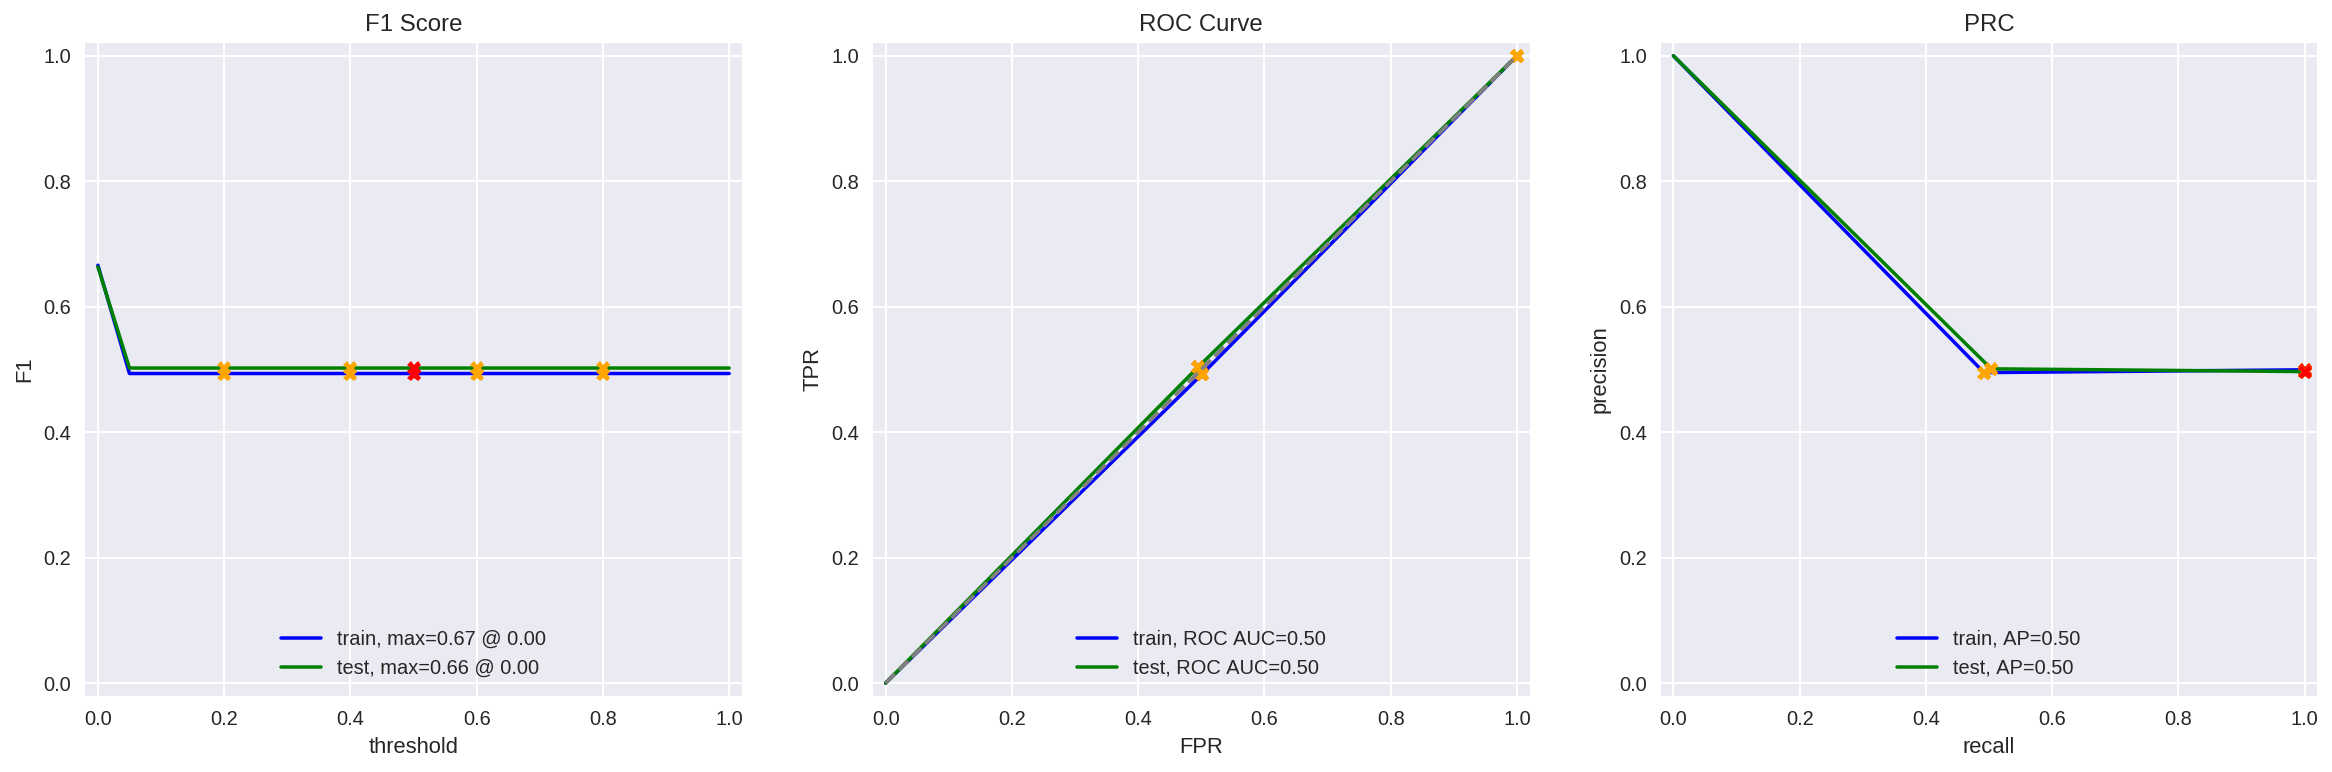

In [28]:
evaluate_model(model_0, train_features, train_target, test_features, test_predict)

 random guessing 50/50

### Model 1 - NLTK, TF-IDF and LR <a class="anchor" id="nltk"></a>

TF-IDF

In [29]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer  = WordNetLemmatizer()

In [30]:
def text_lemma(row):
    text = row['review_norm']
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

df_reviews_train['review_lemma'] = df_reviews_train.apply(text_lemma, axis=1)
df_reviews_test['review_lemma'] = df_reviews_test.apply(text_lemma, axis=1)

In [31]:
stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
corpus_train = df_reviews_train['review_lemma']
corpus_test = df_reviews_test['review_lemma']

# creating a TF-IDF matrix without stop words
train_features_1 = count_tf_idf.fit_transform(corpus_train)
test_features_1 = count_tf_idf.transform(corpus_test)

In [32]:
%%time
model_1 = LogisticRegression()
model_1.fit(train_features_1,train_target)
score = model_1.score(train_features_1, train_target)
print('Score ', score)
test_target = model_1.predict(test_features_1)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score  0.9357455034459573
CPU times: user 4.5 s, sys: 3.68 s, total: 8.18 s
Wall time: 8.19 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.94   1.0
F1         0.94   1.0
APS        0.98   1.0
ROC AUC    0.98   1.0


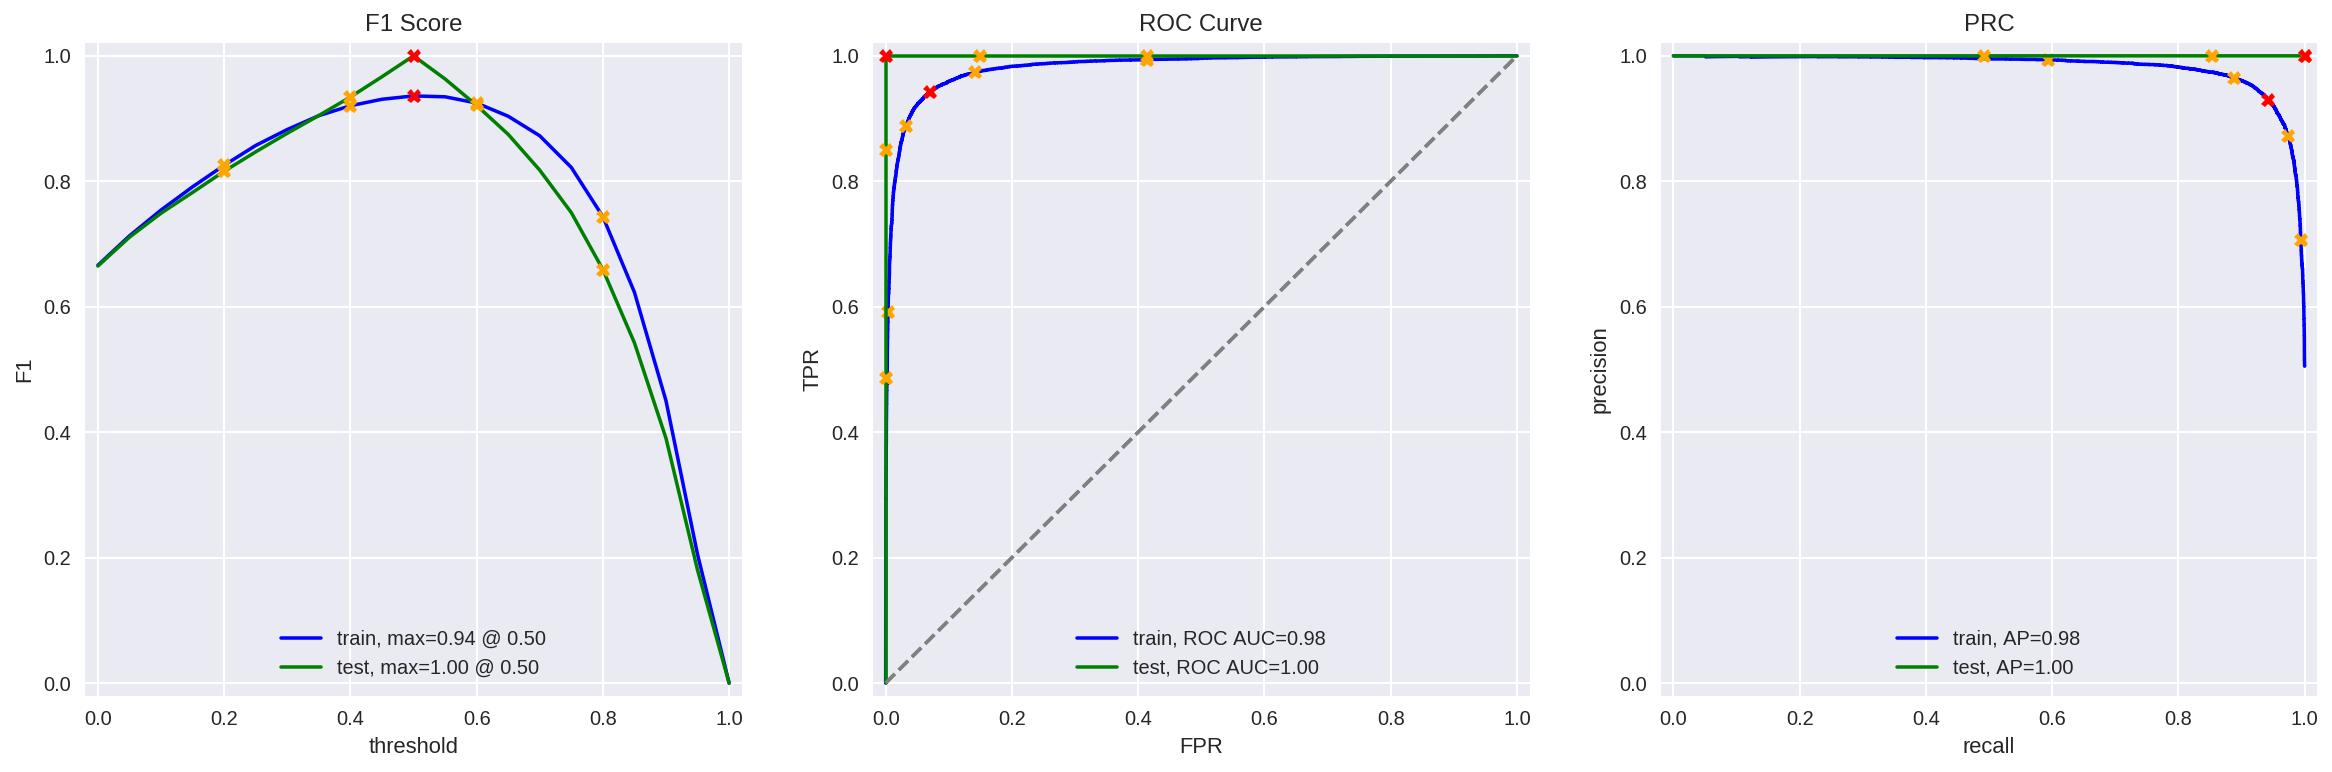

In [33]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF and LR <a class="anchor" id="spacy"></a>

In [34]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [35]:
def text_preprocessing_3(row):
    text = row['review_norm']
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
#     tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [36]:
df_reviews_train['review_lemma_3'] = df_reviews_train.apply(text_preprocessing_3, axis=1)
df_reviews_test['review_lemma_3'] = df_reviews_test.apply(text_preprocessing_3, axis=1)

In [37]:
count_tf_idf = TfidfVectorizer()
corpus_train = df_reviews_train['review_lemma_3']
corpus_test = df_reviews_test['review_lemma_3']

# creating a TF-IDF matrix without stop words
train_features_3 = count_tf_idf.fit_transform(corpus_train)
test_features_3 = count_tf_idf.transform(corpus_test)

In [38]:
%%time
model_3 = LogisticRegression()
model_3.fit(train_features_3,train_target)
score = model_3.score(train_features_3, train_target)
print('Score ', score)
test_target = model_3.predict(test_features_3)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score  0.9311228777945874
CPU times: user 3.71 s, sys: 3.27 s, total: 6.98 s
Wall time: 7 s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.93   1.0
F1         0.93   1.0
APS        0.98   1.0
ROC AUC    0.98   1.0


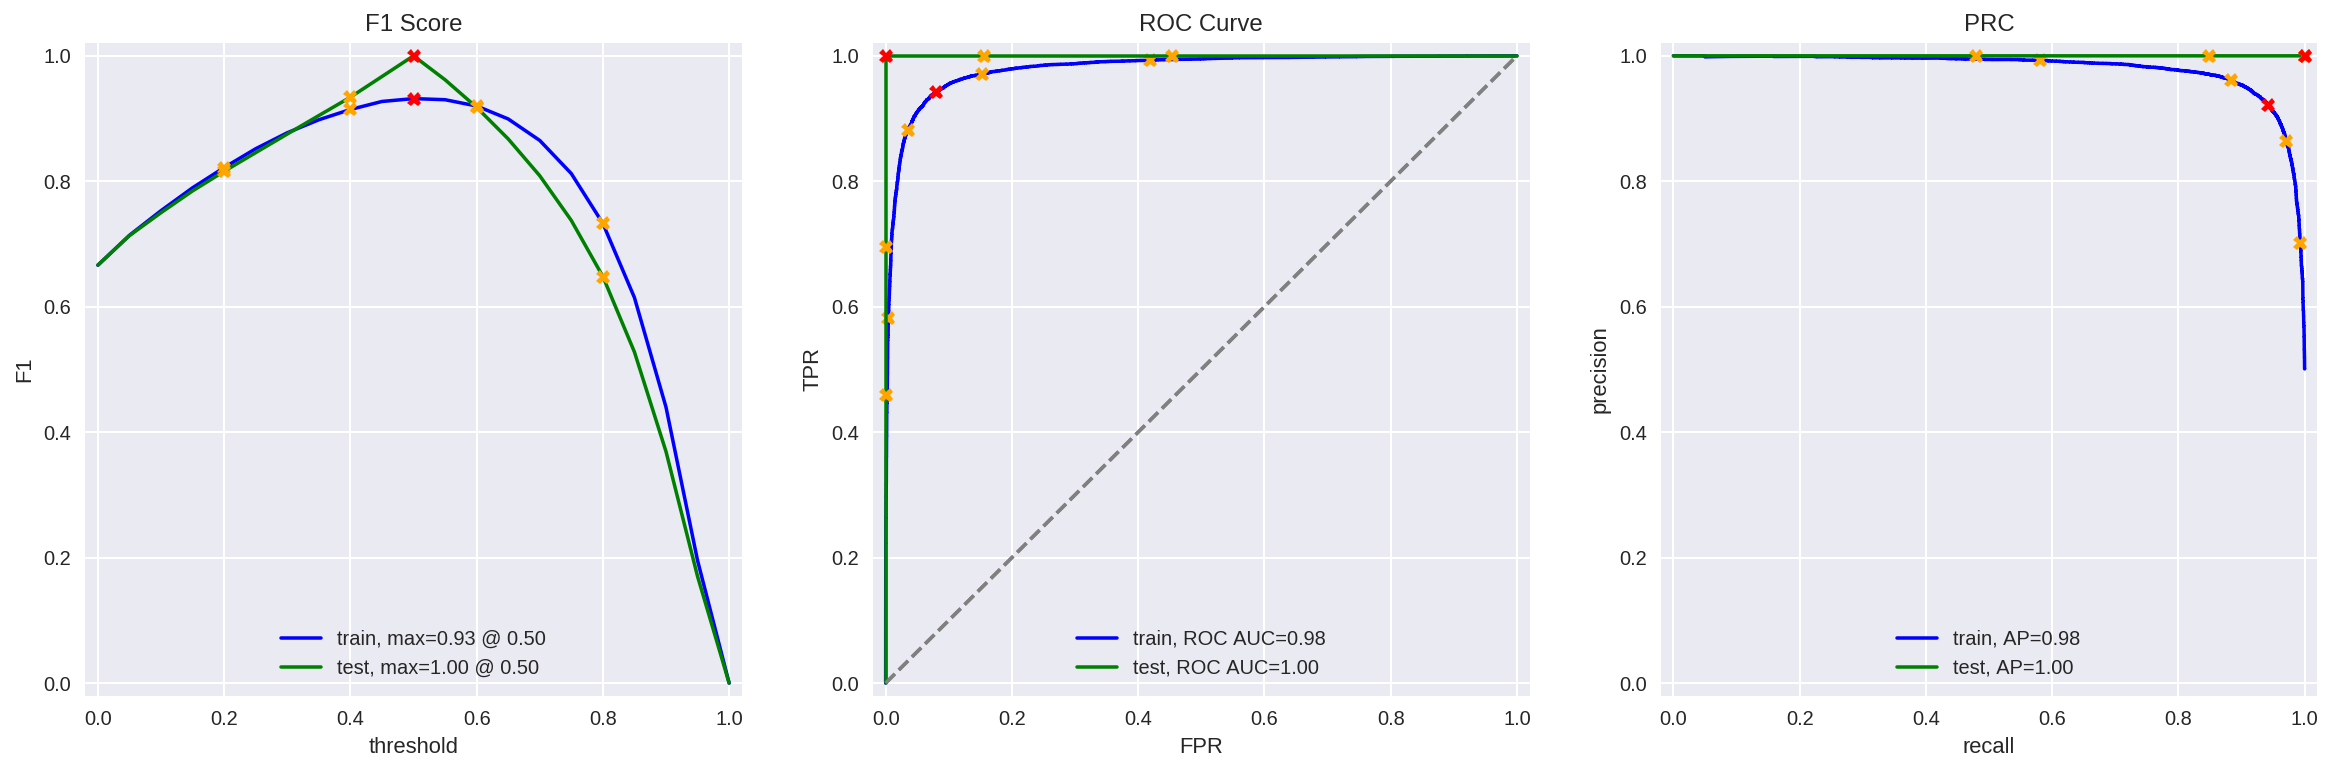

In [39]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier <a class="anchor" id="lgbm"></a>

In [40]:
from lightgbm import LGBMClassifier

In [41]:
count_tf_idf = TfidfVectorizer()
corpus_train = df_reviews_train['review_lemma_3']
corpus_test = df_reviews_test['review_lemma_3']

# creating a TF-IDF matrix without stop words
train_features_4 = count_tf_idf.fit_transform(corpus_train)
test_features_4 = count_tf_idf.transform(corpus_test)

In [42]:
%%time
model_4 = LGBMClassifier()
model_4.fit(train_features_4,train_target)
score = model_4.score(train_features_4, train_target)
print('Score ', score)
test_target = model_4.predict(test_features_4)

Score  0.9090183224071272
CPU times: user 8min 14s, sys: 2.84 s, total: 8min 17s
Wall time: 8min 21s


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.91   1.0
F1         0.91   1.0
APS        0.97   1.0
ROC AUC    0.97   1.0


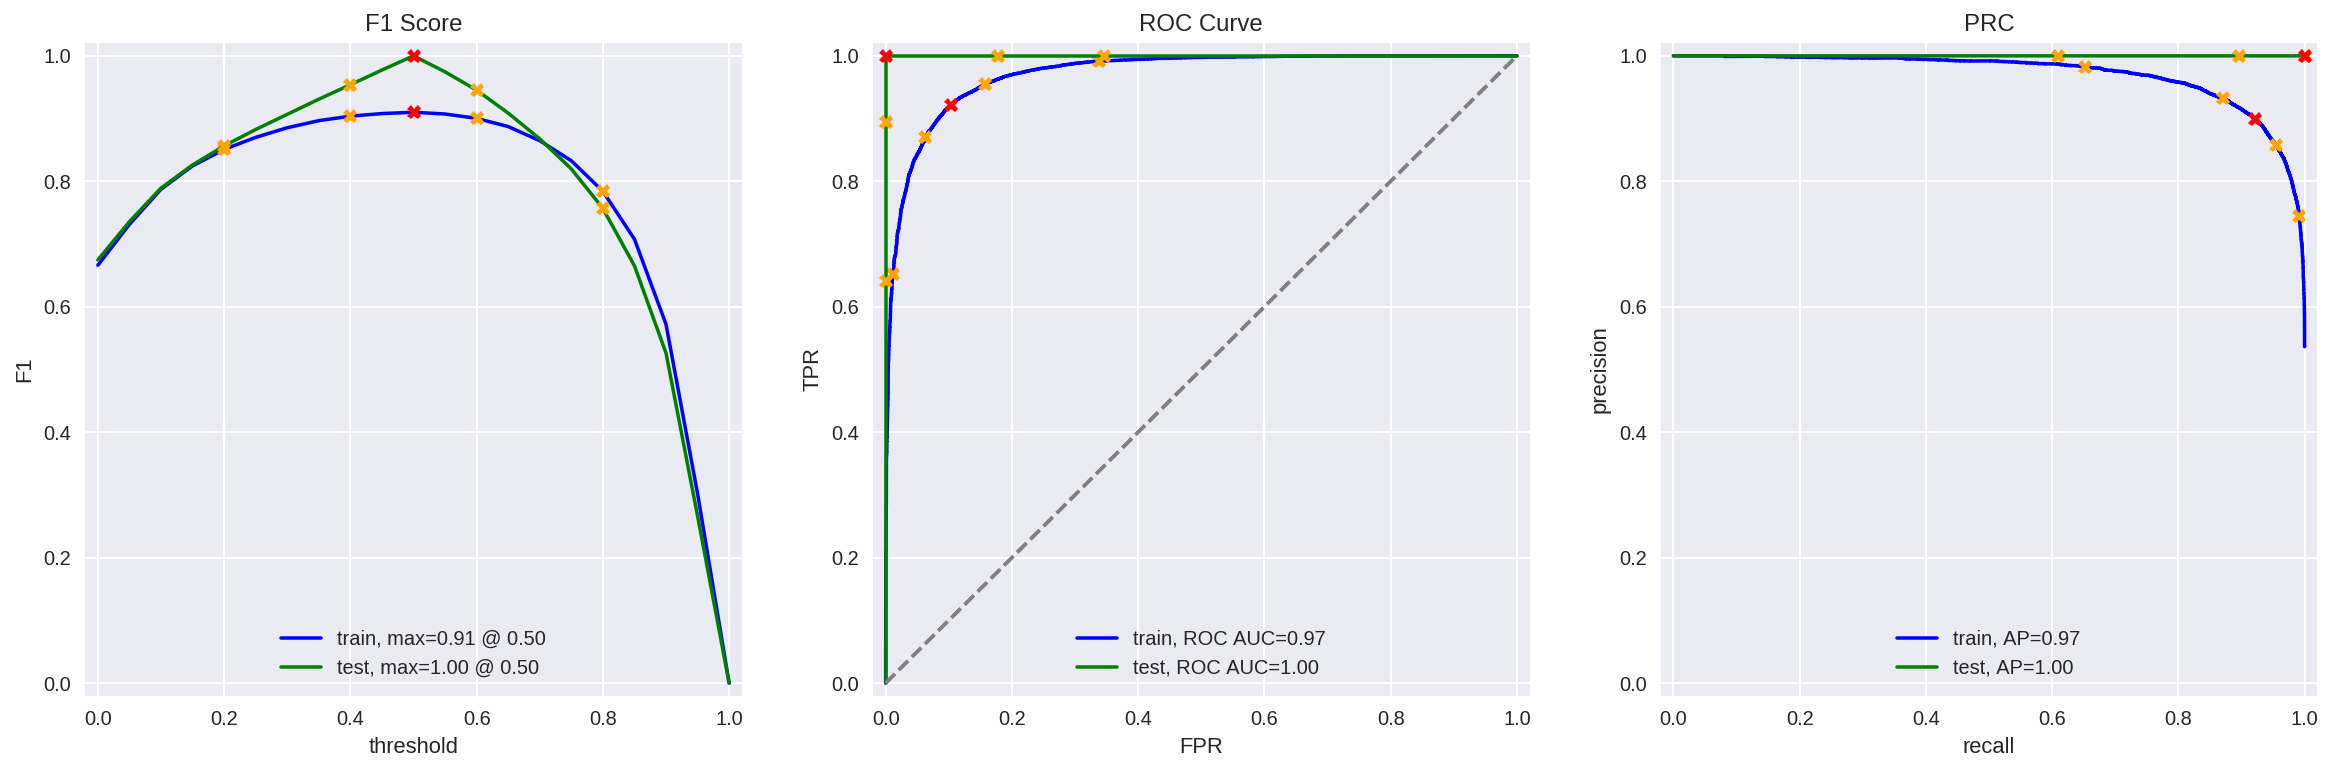

In [43]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)


###  Model 9 - BERT <a class="anchor" id="bert"></a>

In [44]:
import torch
import transformers

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [46]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
    config = transformers.BertConfig.from_pretrained('bert-base-uncased')
    model = transformers.BertModel.from_pretrained('bert-base-uncased')
    
    # <put your code here to create ids_list and attention_mask_list>
    ids_list = texts.apply(lambda x: tokenizer.encode(x.lower(), add_special_tokens=True, truncation=True, max_length=max_length))
    
    ids_list = ids_list.apply(lambda x: np.array(x[:max_length] + [0]*(max_length - len(x))))
    attention_mask_list = ids_list.apply(lambda x: np.where(x != 0, 1, 0))
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        # <put your code here to create attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)].reset_index(drop=True)).to(device)

        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [47]:
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'].iloc[:15], batch_size=10, force_device='cpu')

Using the cpu device.


I ran the BERT_text_to_embeddings for 6 hours+ and also with crashing multiple times. managed to save it as 'features_9.npz' so I can load it.

In [75]:
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [76]:
train_features_9

array([[ 0.16381946,  0.12258451,  0.17697895, ..., -0.40935218,
         0.65103227,  0.14327177],
       [-0.17694014,  0.5676962 ,  0.10393275, ..., -0.31282943,
         0.4764969 ,  0.17113954],
       [ 0.03795413,  0.00260212,  0.01475331, ..., -0.17098737,
         0.6916485 ,  0.2494298 ],
       ...,
       [-0.01841147, -0.47133884,  0.23504956, ..., -0.25624007,
         0.5380592 , -0.1518374 ],
       [-0.16179076,  0.21213835,  0.14977194, ..., -0.230002  ,
         0.57069856, -0.16665524],
       [ 0.26069498,  0.35048974, -0.04214346, ..., -0.3343671 ,
         0.5164956 ,  0.2859892 ]], dtype=float32)

In [77]:
test_features_9

array([[-0.11920506, -0.41049114,  0.2856383 , ..., -0.9501353 ,
         0.5113096 ,  0.19702263],
       [-0.31230935, -0.17189486,  0.50150466, ..., -0.70798224,
         0.7790103 , -0.40753177],
       [-0.40281537, -0.23609738,  0.5801041 , ..., -1.0039322 ,
         0.70351547, -0.3193515 ],
       ...,
       [ 0.0045546 ,  0.08540519,  0.37570694, ..., -0.35341424,
         0.7417898 ,  0.01759247],
       [ 0.07777429, -0.08141518,  0.07999839, ..., -0.3948816 ,
         0.67472094, -0.35015896],
       [ 0.2516941 , -0.20176685,  0.30364716, ..., -0.14505374,
         0.67138684,  0.01789706]], dtype=float32)

I ran the code below for 6 hours+ and also with crashing multiple times. managed to save it as 'features_9.npz' so I can load it.

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cpu')

Using the cpu device.


In [79]:
sample_size=400

In [80]:
target_9 = df_reviews.iloc[:sample_size]['pos']

In [85]:
# train_features_9,test_features_9 are using load from np.load('features_9.npz')
# uncomment below if not using load.
# train_features_9,test_features_9,train_target,test_target = train_test_split(train_features_9,target_9, test_size=0.5, random_state=12345)

In [84]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [86]:
model_9 = LogisticRegression()
model_9.fit(train_features_9,train_target)
score = model_9.score(train_features_9, train_target)
print('Score ', score)
test_target = model_9.predict(test_features_9)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score  0.8758614893259371


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.88   1.0
F1         0.88   1.0
APS        0.95   1.0
ROC AUC    0.95   1.0


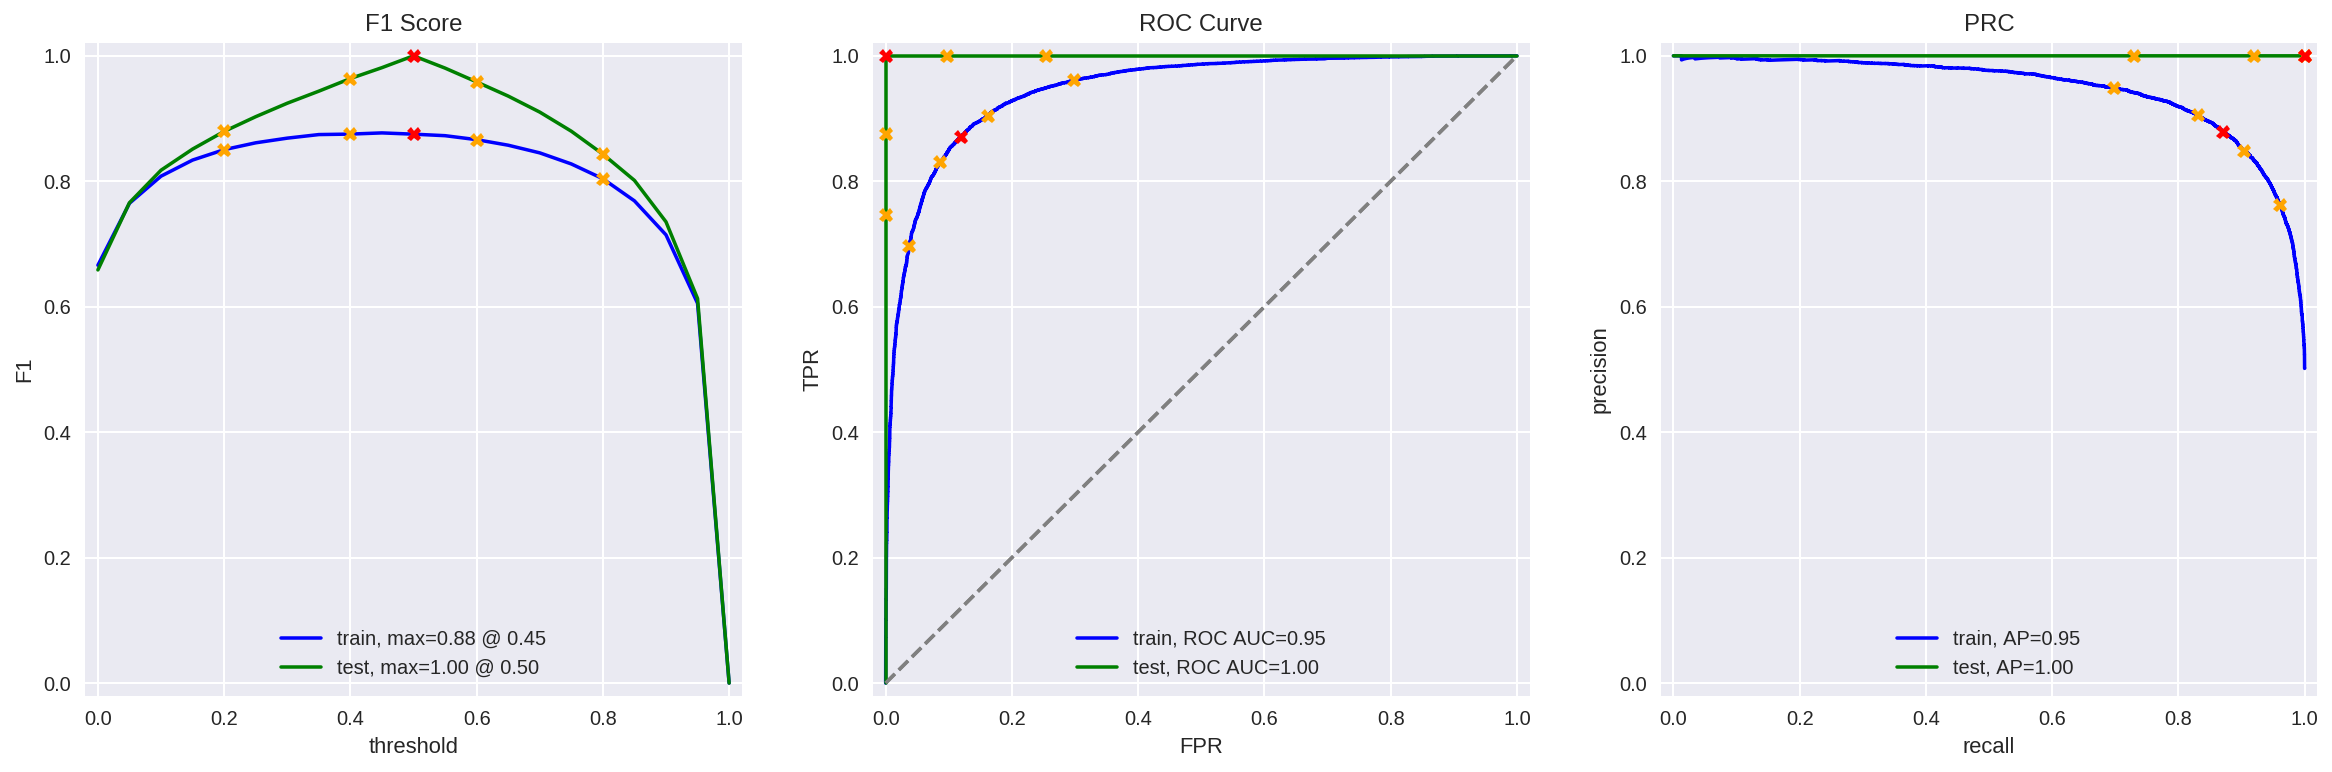

In [87]:
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

### Evaluation Model <a class="anchor" id="modelevaluation"></a>

- DummyClassifier has very bad results of 0.5, similar to random guessing 50/50. 
- NLTK, TF-IDF and LR has best result with : Accuracy = 0.94, F1 = 0.94, APS = 0.98, ROC AUC = 0.98. This model is also fast.
- spaCy, TF-IDF and LR has very good results, with Accuracy = 0.92, F1 = 0.92, APS = 0.97, ROC AUC = 0.97.
- spaCy, TF-IDF and LGBMClassifier has  Accuracy = 0.91, F1 = 0.91, APS = 0.97, ROC AUC = 0.97. but it took long time to train and does not worth it.
- BERT has Accuracy = 0.88, F1 = 0.88, APS = 0.95, ROC AUC = 0.95.
- BERT model took really long time to train using cpu. In my case it took me around 6+ hours and with multiple crashes as well for couple days,  not very recommended if we can't use good gpu. The conclusion is there might be hardware limitations that occur in practice and or real life. 


## My Reviews  <a class="anchor" id="reviews"></a>

In [51]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews.apply(clean_text, axis=1)

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Model 1

In [52]:
my_reviews['review_lemma'] = my_reviews.apply(text_lemma, axis=1)
count_tf_idf = TfidfVectorizer()
my_reviews_corpus_train = df_reviews_train['review_lemma']
my_reviews_corpus_test = my_reviews['review_lemma']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_1 = count_tf_idf.fit_transform(my_reviews_corpus_train)
my_reviews_test_features_1 = count_tf_idf.transform(my_reviews_corpus_test)

In [60]:
test_features_1.size

2205939

In [59]:
texts = my_reviews['review_lemma']

my_reviews_pred_prob = model_1.predict_proba(test_features_1)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.59:  I did not simply like it, not my kind of movie.
0.16:  Well, I was bored and felt asleep in the middle of the movie.
0.35:  I was really fascinated with the movie
0.07:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.31:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.94:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.81:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.71:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 3

In [61]:
my_reviews['review_lemma_3'] = my_reviews.apply(text_preprocessing_3, axis=1)
count_tf_idf = TfidfVectorizer()
my_reviews_corpus_train = df_reviews_train['review_lemma_3']
my_reviews_corpus_test = my_reviews['review_lemma_3']

# creating a TF-IDF matrix without stop words
my_reviews_train_features_3 = count_tf_idf.fit_transform(my_reviews_corpus_train)
my_reviews_features_3 = count_tf_idf.transform(my_reviews_corpus_test)

In [62]:
texts = my_reviews['review_lemma_3']

my_reviews_pred_prob = model_3.predict_proba(my_reviews_features_3)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.84:  I did not simply like it, not my kind of movie.
0.95:  Well, I was bored and felt asleep in the middle of the movie.
0.51:  I was really fascinated with the movie
0.83:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.77:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.61:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.97:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.10:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 4

In [64]:
texts = my_reviews['review_lemma_3']

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_3)

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i][0]:.2f}:  {review}')

0.45:  I did not simply like it, not my kind of movie.
0.80:  Well, I was bored and felt asleep in the middle of the movie.
0.42:  I was really fascinated with the movie
0.61:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.33:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.46:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.71:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.27:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


### Model 9

In [66]:
train_features_9 

array([[ 0.16381946,  0.12258451,  0.17697895, ..., -0.40935218,
         0.65103227,  0.14327177],
       [-0.17694014,  0.5676962 ,  0.10393275, ..., -0.31282943,
         0.4764969 ,  0.17113954],
       [ 0.03795413,  0.00260212,  0.01475331, ..., -0.17098737,
         0.6916485 ,  0.2494298 ],
       ...,
       [-0.01841147, -0.47133884,  0.23504956, ..., -0.25624007,
         0.5380592 , -0.1518374 ],
       [-0.16179076,  0.21213835,  0.14977194, ..., -0.230002  ,
         0.57069856, -0.16665524],
       [ 0.26069498,  0.35048974, -0.04214346, ..., -0.3343671 ,
         0.5164956 ,  0.2859892 ]], dtype=float32)

In [89]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(my_reviews['review'].str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  I did not simply like it, not my kind of movie.
0.01:  Well, I was bored and felt asleep in the middle of the movie.
0.99:  I was really fascinated with the movie
0.00:  Even the actors looked really old and disinterested, and they got paid to be in the movie. What a so
0.18:  I didn't expect the reboot to be so good! Writers really cared about the source material
0.98:  The movie had its upsides and downsides, but I feel like overall it's a decent flick. I could see my
0.05:  What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even ki
0.96:  Launching on Netflix was a brave move & I really appreciate being able to binge on episode after epi


## Conclusions <a class="anchor" id="allconclusion"></a>

- NLTK, TF-IDF and LR has best result, faster and very efficient
- NLTK and spaCy doesn't have significant difference
- LR and LGBMClassifier has significant difference on time for train the model
- BERT has limitation of hardware resources, not recommended if we don't have the resources available. 